In [1]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2023-02-09 15:36:32.553423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 15:36:33.404818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-09 15:36:33.404954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

2.11.0


In [2]:
#read data
data = pd.read_csv("./data/train.csv")
#shuffle data
data = data.sample(frac=1)

#print data
#data.head(10)
#data["keyword"].unique()

In [13]:
data.target

6864    0
5782    0
4790    1
4522    0
3106    0
       ..
98      0
6770    1
7266    0
2870    1
6365    1
Name: target, Length: 7613, dtype: int64

In [3]:
#one hot encode target
# classes = [[0,1][source] for source in data.target]
# target = to_categorical(classes)
# print target
# target[10]

In [4]:
MAX_LEN = 22
MAX_TOKENS = 100000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, 
    max_tokens=MAX_TOKENS
    #, vocabulary = np.array(["Our","are", "in"])
)

2023-02-09 15:36:35.974912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 15:36:35.988747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 15:36:35.990538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 15:36:35.992840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
preprocessing_layer.adapt(data.text)


In [6]:
preprocessing_layer(data.text[:10])

<tf.Tensor: shape=(10, 22), dtype=int64, numpy=
array([[21672,    31,    21,    15,    12,   106,   684,    43, 10838,
          473,     6,    56,    61,     5,  5122,     5,   354,    16,
           79,    21,  1716,     7],
       [   46,    16,    79,     6,    63,     3,   178,  1104,  1560,
           79,    21,   423,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  806,    96,     3,   472,   111,    29,    50,   290,   482,
          387,  1699,   246,     5, 11648,    36,    15,    23,   113,
         3401,  2673,    66,     2],
       [ 1588,  4043,   342,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 8229,   278,   724,     3,    69,     6,    43,  2696,    59,
           96,  3584,    28,     4,  1207,  6456,     7,   476,     5,
          161,     0,     0,     0],
       [ 5611,     2,  1518,   893,     4,     3,   503, 

In [7]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

22699

In [69]:
inputs = Input(shape=(1,),dtype=tf.string)
x = preprocessing_layer(inputs)
x = Embedding(VOCAB_SIZE+1,500,mask_zero=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x= GRU(10)(x)
outputs = Dense(1,activation="sigmoid")(x)

model = keras.Model(inputs=inputs,outputs=outputs,name="modeltest")
model.summary()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy",metrics=["Accuracy"])
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=["Accuracy"])
modelhistory = model.fit(
    data.text[:6000],
    data.target[:6000], 
    epochs=50,
    batch_size=50, 
    validation_data=(data.text[6000:],data.target[6000:]),
    callbacks=[EarlyStopping(patience=10)]
)

Model: "modeltest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 22)               0         
 torization)                                                     
                                                                 
 embedding_12 (Embedding)    (None, 22, 500)           11350000  
                                                                 
 dropout_12 (Dropout)        (None, 22, 500)           0         
                                                                 
 gru_12 (GRU)                (None, 10)                15360     
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                         

<AxesSubplot:>

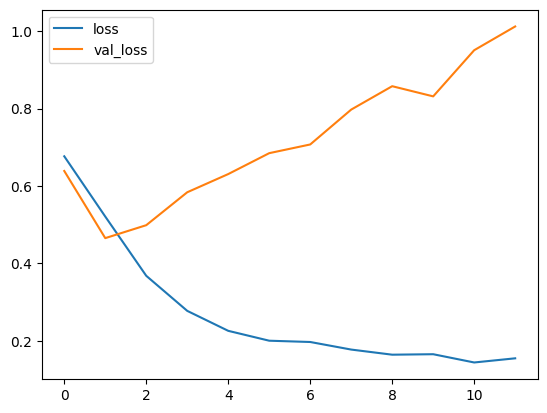

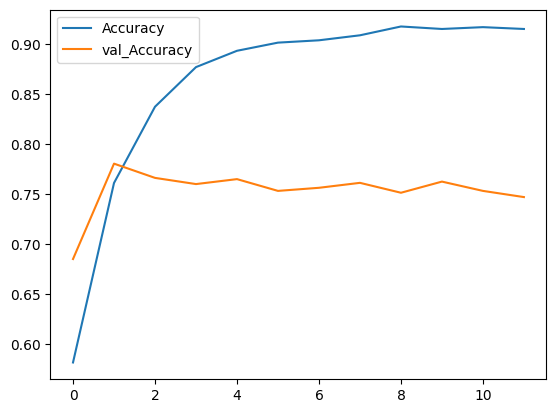

In [67]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]].plot()
pd.DataFrame(modelhistory.history)[["Accuracy","val_Accuracy"]].plot()

<AxesSubplot:>

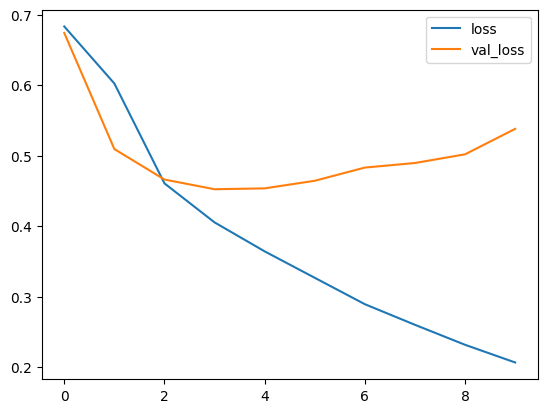

In [65]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]][:10].plot()

In [23]:
model.predict(data.text[7000:7001])

1/1 [==============================] - 1s 1s/step


array([[0.99909437]], dtype=float32)

In [ ]:
data.text[7000:7001]